###     Hi there! the following code is the newest version of 'ML-spatial-regression-testing.html', 
    the original code developed and implemented in the paper: 

    'Three-dimensional modelling using spatial regression machine learning and hydrogeological basement VES'

    Authors: Gastón M. Mendoza Veirana, Santiago Perdomo, Jerónimo Ainchil

    PII: S0098-3004(21)00198-9
    DOI: https://doi.org/10.1016/j.cageo.2021.104907
    Reference: CAGEO 104907

    Published on Computers and Geosciences
    Received Date: 20 November 2020
    Revised Date: 1 August 2021
    Accepted Date: 3 August 2021

    Please cite this article as: 
    Mendoza Veirana, Gastón .M., Perdomo, Santiago., Ainchil, Jerónimo., Three-dimensional
    modelling using spatial regression machine learning and hydrogeological basement VES, Computers
    and Geosciences (2021), doi: https://doi.org/10.1016/j.cageo.2021.104907.'  

In [9]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import time
import statistics
import sys
import seaborn as sns; sns.set()

from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor as ETR
from utils import *
from plots import *

# Get notebook and parent dir
current_dir = os.path.dirname(os.path.abspath('__file__')) 
parent_dir = os.path.dirname(current_dir)

np.set_printoptions(threshold=sys.maxsize)

In [10]:
'''
    You can also download the input DataSet from:
    http://dx.doi.org/10.17632/vjhy9gkzg3.1
'''

datafolder = 'data' # data folder
file_path = os.path.join(datafolder, "DFCI.csv")
data = pd.read_csv(file_path, sep=',', header=0)

data.head()

,Unnamed: 0,N,Lat,Long,Alt,Coast,POB,Lat coast,Long coast
0,1,268,-38.032135,-60.097628,194,85.275872,170,-38.799163,-59.698377
1,2,269,-38.030476,-60.091791,194,85.959611,164,-38.803654,-59.717198
2,3,270,-37.989224,-60.070773,205,91.152355,155,-38.809109,-59.735254
3,4,222,-37.989224,-60.060137,202,91.989740,132,-38.816641,-59.757319
4,5,223,-38.009114,-60.085755,197,90.316748,152,-38.821483,-59.775189


In [11]:
data.describe() # Main statistics of the data

,Unnamed: 0,N,Lat,Long,Alt,Coast,POB,Lat coast,Long coast
count,48.00,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,24.50,290.979167,-38.307230,-60.354874,137.541667,63.894951,-140.041667,-38.881943,-60.205143
std,14.00,314.446795,0.199179,0.251737,33.523544,17.001130,227.170379,0.047163,0.326362
min,1.00,222.000000,-38.641763,-60.924275,91.000000,35.923735,-493.000000,-38.980657,-60.936830
25%,12.75,233.750000,-38.458691,-60.514414,111.750000,51.253764,-372.500000,-38.919702,-60.429244
50%,24.50,246.500000,-38.329171,-60.256175,123.000000,60.931000,-109.000000,-38.877225,-60.194764
75%,36.25,258.250000,-38.131680,-60.157658,161.500000,79.441831,61.500000,-38.846233,-59.935703
max,48.00,2422.000000,-37.989224,-60.060137,205.000000,91.989740,170.000000,-38.799163,-59.698377


In [12]:
'''

    Structuring data

'''
X = pd.DataFrame(data, columns=['Lat', 'Long'])
target = ["POB"]
Y = pd.DataFrame(data, columns=['POB'])
Y = Y.values.ravel()
print("Depths:", Y)

Xx =  pd.DataFrame(data, columns=['Lat', 'Long', "Coast", "Alt"])
x_ =  data["Lat"]
y_ =  data["Long"]
z_ = -data["POB"]

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
Xx_norm = scaler.fit_transform(Xx)

Depths: [ 170  164  155  132  152  151  122  117  118  141  120   81   55   55
   18   25  -15  -13  -28  -30  -52  -75  -78  -60 -140 -150 -190 -190
 -140 -166 -244 -348 -269 -370 -453 -493 -476 -416 -385 -409 -458 -489
 -455 -333 -389 -322 -380 -482]


In [13]:
'''

    Genering the point cloud

'''
latcoast = data["Lat coast"]
longcoast = data["Long coast"]
Lat = x_.values.reshape(-1,1)

n_cloud = 4000
pf = PolynomialFeatures(degree = 4)    # usaremos polinomios de grado 3
xpol = pf.fit_transform(Lat)           # transformamos la entrada en polinómica
regresion_lineal = LinearRegression()  # creamos una instancia de LinearRegression
regresion_lineal.fit(xpol, y_) 
Lat = np.linspace(x_.min(), x_.max(), n_cloud)
ruido = np.random.randn(n_cloud) * 0.08
#Long = (Lat**4)*regresion_lineal.coef_[4] + (Lat**3)*regresion_lineal.coef_[3] + (Lat**2)*regresion_lineal.coef_[2] + Lat*regresion_lineal.coef_[1] + regresion_lineal.intercept_ + ruido
Long = pd.read_excel("data/Long_cloud.xlsx")

xy = np.column_stack((Lat, Long))
X_norm_cloud = scaler.fit_transform(xy)

filter_arr, lat_tran, long_tran = [], [], []

for i in xy:
    if i[0] > -38.265 and i[0] < -38.25:
        lat_tran.append(i[0])
        long_tran.append(i[1])
        filter_arr.append(True)
    else:
        filter_arr.append(False)

xy_tran = xy[filter_arr]

(array([ 7.,  6.,  3.,  2.,  3.,  3.,  5.,  5.,  3., 11.]),
 array([-493. , -426.7, -360.4, -294.1, -227.8, -161.5,  -95.2,  -28.9,
          37.4,  103.7,  170. ]),
 <BarContainer object of 10 artists>)

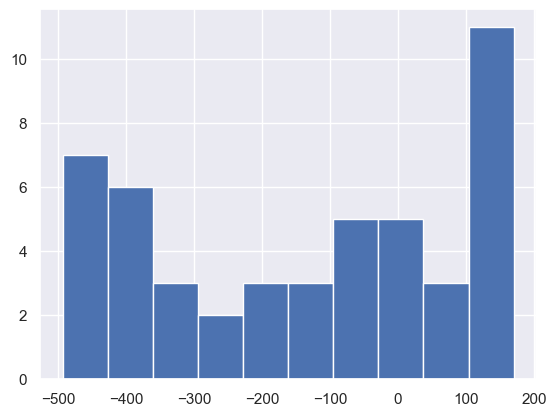

In [14]:
plt.hist(data.POB) # Historial of Optimal Depth Basement (POB)

<Axes: >

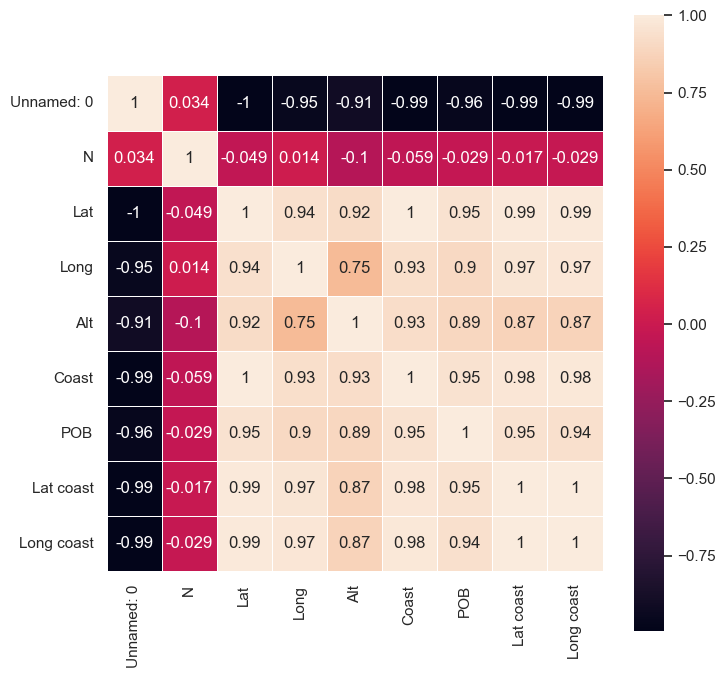

In [15]:
'''

    Correlation matrix

'''
corr_matrix = np.corrcoef(data.T) # Correlation Matrix

plt.subplots(figsize=(8, 8))
sns.heatmap(corr_matrix.T, square=True, annot=True, cbar=True, linewidths=.5,
            xticklabels=data.columns, yticklabels=data.columns )

# -- Support Vector Machine --

In [16]:
# Define hyperparameters for C and Gamma
C_values = np.array([31.6, 100, 316, 1000, 3160, 10000, 31600, 100000, 316000])
Gamma_values = np.array([0.0001, 0.0031, 0.01, 0.0316, 0.1, 0.316, 1, 1.77, 3.16, 5.62, 10])

# Initialize matrices to store results
EXPMSE_TEST = np.zeros((len(C_values), len(Gamma_values)))
EXPMSE_TRAIN = np.zeros((len(C_values), len(Gamma_values)))
EXPS_TEST = np.zeros((len(C_values), len(Gamma_values)))
EXPS_TRAIN = np.zeros((len(C_values), len(Gamma_values)))
EXPS_CV = np.zeros((len(C_values), len(Gamma_values)))

def train_and_evaluate_svm(C, gamma, x_train, x_test, y_train, y_test):
    """
    Train the SVR model and evaluate performance.
    """
    model = SVR(kernel="rbf", C=C, gamma=gamma)
    model.fit(x_train, y_train)
    
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    cv_score = np.mean(cross_val_score(model, x_train, y_train, cv=cv, n_jobs=-1))
    
    Y_train_pred = model.predict(x_train)
    Y_test_pred = model.predict(x_test)
    
    MSE_test = np.mean((Y_test_pred - y_test) ** 2)
    MSE_train = np.mean((Y_train_pred - y_train) ** 2)
    score_test = r2_score(y_test, Y_test_pred)
    score_train = r2_score(y_train, Y_train_pred)
    
    return MSE_test, MSE_train, score_test, score_train, cv_score

# Iterate over combinations of C and Gamma
for c_index, C in enumerate(C_values):
    for gamma_index, gamma in enumerate(Gamma_values):
        # Accumulate results over 100 iterations with different train/test splits
        mse_test_list, mse_train_list = [], []
        score_test_list, score_train_list, cv_score_list = [], [], []
        
        for i in range(100):
            x_train, x_test, y_train, y_test = train_test_split(X_norm, Y, test_size=0.2, random_state=i)
            MSE_test, MSE_train, score_test, score_train, cv_score = train_and_evaluate_svm(C, gamma, x_train, x_test, y_train, y_test)
            
            mse_test_list.append(MSE_test)
            mse_train_list.append(MSE_train)
            score_test_list.append(score_test)
            score_train_list.append(score_train)
            cv_score_list.append(cv_score)
        
        # Store average results if cross-validation score is non-negative
        if np.mean(cv_score_list) >= 0:
            EXPMSE_TEST[c_index, gamma_index] = np.mean(mse_test_list)
            EXPMSE_TRAIN[c_index, gamma_index] = np.mean(mse_train_list)
            EXPS_TEST[c_index, gamma_index] = np.mean(score_test_list)
            EXPS_TRAIN[c_index, gamma_index] = np.mean(score_train_list)
            EXPS_CV[c_index, gamma_index] = np.mean(cv_score_list)

# Call the plot function
plot_svm_results(C_values, Gamma_values, EXPS_TEST, EXPS_TRAIN, EXPS_CV, EXPMSE_TEST, EXPMSE_TRAIN)

# Output the best results
best_test_score = np.max(EXPS_TEST)
best_c_index, best_gamma_index = np.unravel_index(np.argmax(EXPS_TEST), EXPS_TEST.shape)
best_c = C_values[best_c_index]
best_gamma = Gamma_values[best_gamma_index]
best_mse_test = EXPMSE_TEST[best_c_index, best_gamma_index]

print("Best SVM Test Score:", best_test_score)
print("Best SVM Test MSE:", best_mse_test)
print(f"Best parameters: C: {best_c}, Gamma: {best_gamma}")

Best SVM Test Score: 0.9654586368767474
Best SVM Test MSE: 1411.8711836645916
Best parameters: C: 1000.0, Gamma: 3.16


   ###     SVMR* Variance calcule

In [17]:
'''

    Calculing E[j(x)]

'''
n = len(X)

X_norm = pd.DataFrame(scaler.fit_transform(X))
Xx_norm = pd.DataFrame(scaler.fit_transform(Xx))
e=100
d = range(0,e)   

values_depths_svr = []
sEj = []

slalista = [[]]*n
for l in range(n):
    slalista[l] = [l]

SVMR = SVR(kernel="rbf", C=best_c, gamma = best_gamma)
EGX_4depth  = []

for i in d:
    esaa = []
    #Secondary features:
    #x_train, x_test, y_train, y_test = train_test_split(Xx_norm, Y, test_size=0.2, random_state=i)
    
    x_train, x_test, y_train, y_test = train_test_split(X_norm, Y, test_size=0.2, random_state=i)

    SVMR.fit(x_train, y_train)
    sTest = SVMR.predict(x_test)
    eindex = []
    eindex = x_test.index

    for o in range(len(y_test)):
        slalista[eindex[o]].append(sTest[o])

for u in range(n):
    slalista[u].pop(0)
lalista4depth = []

for p in range(n):
    lalista4depth.append(sum(slalista[p])/len(slalista[p]))
sEj.append(lalista4depth)

# print("Average prediction of depths using only train data (no prone tree):", sEj)

In [18]:
'''

    Calculing variance

'''
e=100
d = range(0,e)    
k = range(2,11)
tvariance = []

SVMR = SVR(kernel="rbf", C=best_c, gamma = best_gamma)
esperado100 = []

for i in d:

    x_train, x_test, y_train, y_test = train_test_split(X_norm, Y, test_size=0.2, random_state=i)
    SVMR.fit(x_train, y_train)
    sTest = SVMR.predict(x_test)
    eindex = []
    eindex = x_test.index
    sum10 = []
    
    for t in range(len(sTest)):
        resta2 = (sTest[t] - sEj[0][eindex[t]])**2
        sum10.append(resta2)
    sume = sum(sum10)/len(sum10)
    esperado100.append(sume)
    
svariance = sum(esperado100)/len(esperado100)
print("SVM* variance:", svariance)

SVM* variance: 343.6617879266778


 ### SVMR* 3D graph & Smoothness

SVM* Smooth Index: 1.0


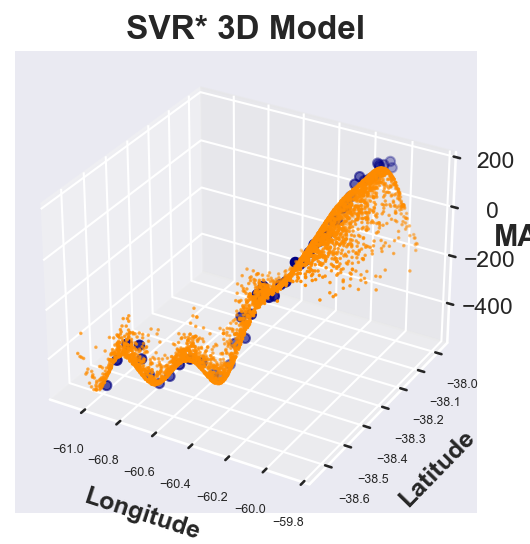

In [19]:
SVMR = SVR(kernel="rbf", C=best_c, gamma = best_gamma)
SVMR.fit(X_norm, Y)

z_SVM = SVMR.predict(X_norm_cloud)
    
title = "SVR* 3D Model"
threedgraph(y_, x_, z_, Long, Lat, z_SVM, "simple", title, long_tran, lat_tran)

soft_index = len(np.unique(z_SVM))/n_cloud
print("SVM* Smooth Index:", soft_index)

### SVMR* Computing Time

In [20]:
'''

SVMR* time performance

'''
SVMR = SVR(kernel="rbf", C=1000, gamma = 3.16)
scaler = MinMaxScaler()

timme=[]
for i in range(1000):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=i)
    time_start = time.perf_counter() #Tomamos el tiempo 
    
    Y_norm = (y_train-min(y_train))/(max(y_train)-min(y_train))
    X_norm = scaler.fit_transform(x_train)
    SVMR.fit(X_norm,Y_norm)
    
    time_elapsed = (time.perf_counter() - time_start)
    timme.append(time_elapsed)
    
finaltime=np.mean(timme)
print(finaltime)

0.0018950301999848306


# -- Simple Tree --


Results in function of tree prone
Score Test: [0.8849246555629311, 0.9291128572470541, 0.9391586418818195, 0.9424940374713883, 0.9440778586162699, 0.9452191877458155, 0.9467872448109379, 0.9475037924273952, 0.9476759900870149]
Score Train: [0.9494229393757005, 0.9806773364155267, 0.991271655014994, 0.995948363976459, 0.9989139538474818, 0.9996909696170698, 0.9999521799858286, 0.9999969702325916, 1.0]
Score CV: [0.8836926695514109, 0.9233405694730495, 0.9285454267680956, 0.9314256011302929, 0.9321922870730073, 0.9320812129140761, 0.9318183695810803, 0.9316127115782916, 0.9316127115782916]
MSE Train: [2533.8065469632706, 970.351757366902, 438.2588540100251, 203.3123442982456, 54.334080827067666, 15.4234649122807, 2.3977192982456144, 0.15157894736842104, 0.0]
MSE Test: [4871.683779510596, 3068.3225225644173, 2630.607433199799, 2451.3534135402497, 2401.5614211337866, 2358.711833333333, 2290.8648888888883, 2258.4439999999995, 2252.3229999999994]
Variance: [1445.9988695733111, 776.0413044555

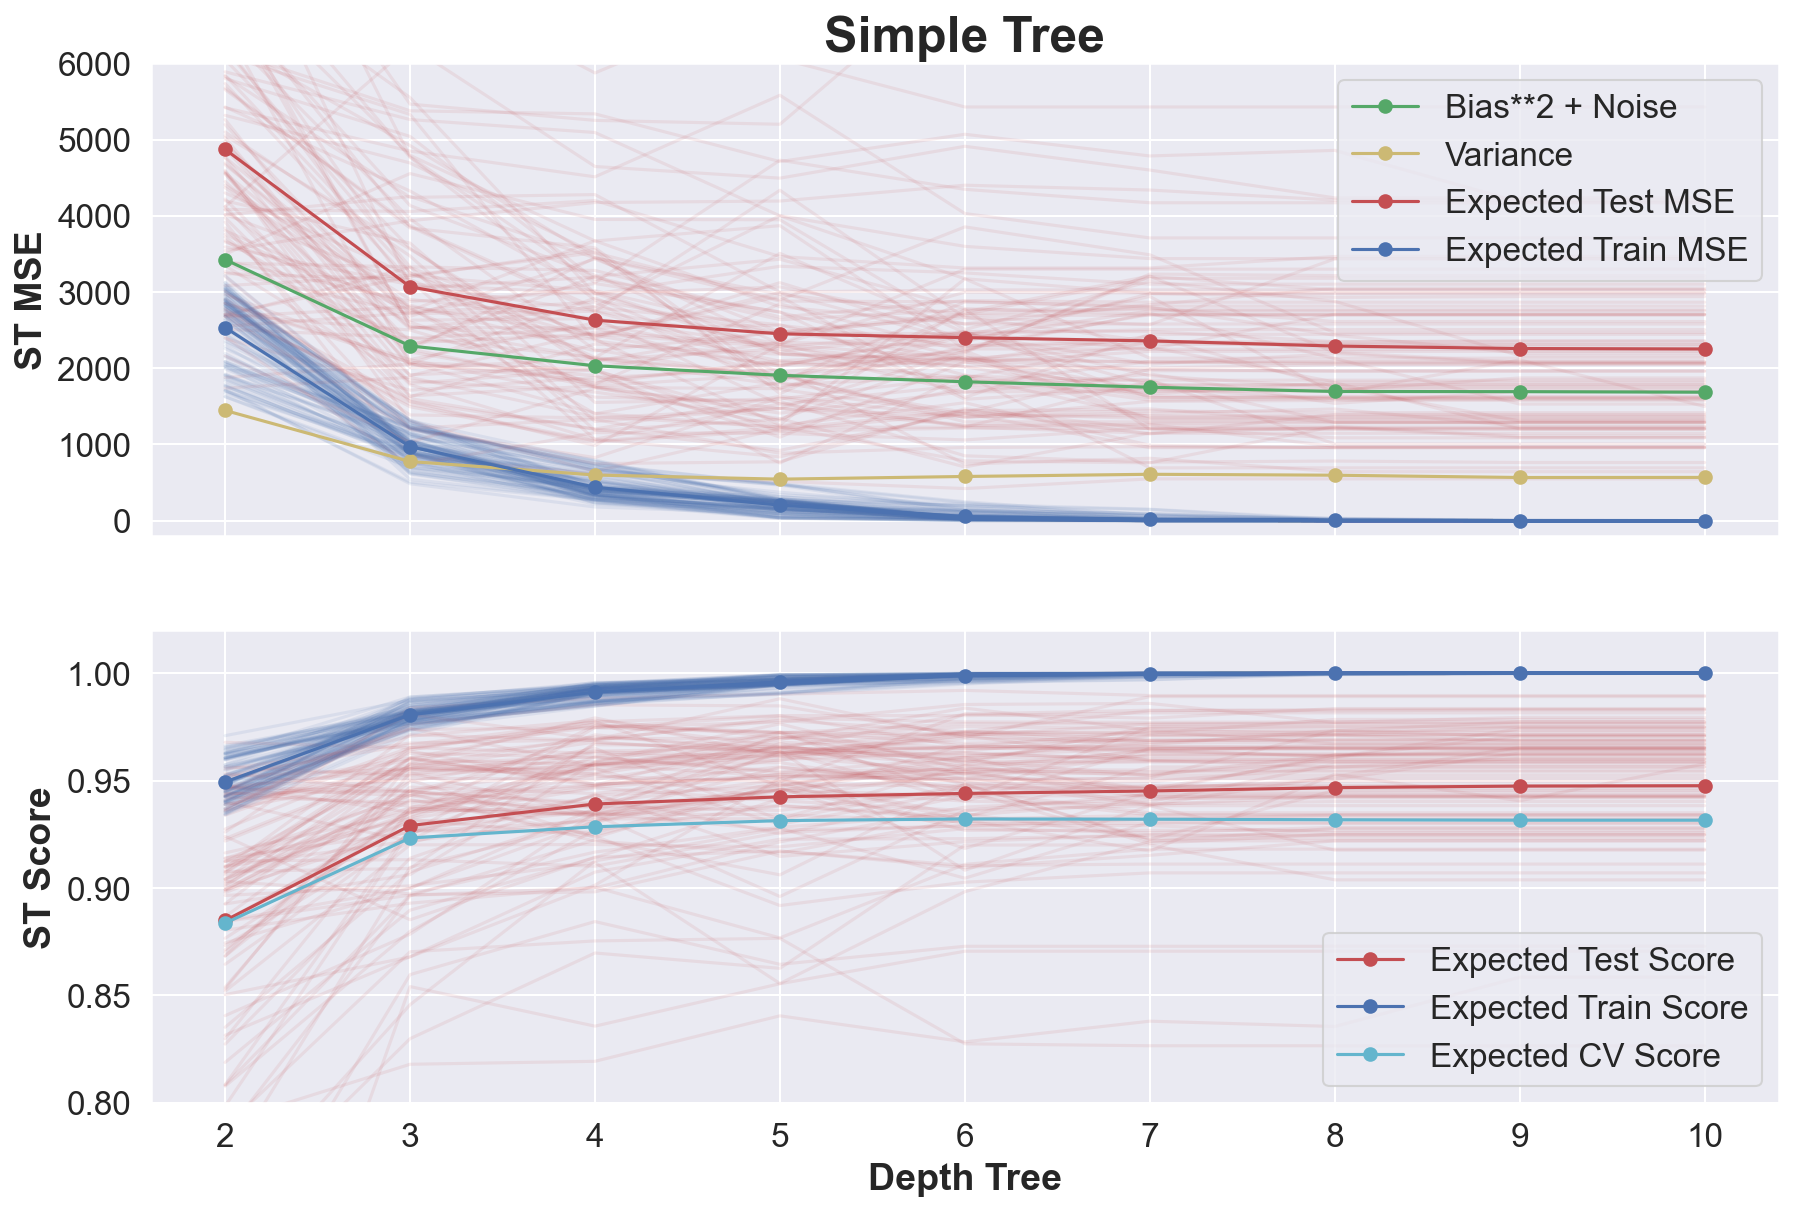

In [21]:
'''

Simple Tree implementation

'''

d = range(0,100)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(14, 9))

''' Defining our lists '''

scoretest, scoretrain, testacum, trainacum, strain, stest, scv, Y_pred_totalacum, valores = [], [], [], [], [], [], [], [], []

k = range(2,11)
dataacum = np.zeros((9, n, 100))

for i in d:
    index = []
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=i)
    
    #x_train, x_test, y_train, y_test = train_test_split(Xx, Y, test_size=0.2, random_state=i) # Secondary variables

    msetrain, msetest, scoretest, scoretrain, scorecv, Y_pred_depthacum = [], [], [], [], [], []
        
    for j in k:
        #max_features is the K value
        #random_state is the seed 
        
        tree = DecisionTreeRegressor(max_depth = j, max_features=2, random_state=50)
        tree.fit(x_train, y_train)
        cv = KFold(n_splits = 5, shuffle=True, random_state=1)
        Y_pred = tree.predict(x_train)   
        score_cv = np.mean(cross_val_score(tree, x_train, y_train, cv = cv, n_jobs=-1))
        score_train = r2_score(y_train, Y_pred)
        Y_test = tree.predict(x_test)
        MSE_test = sum((Y_test-y_test)**2)/len(y_test)
        MSE_train = sum((Y_pred-y_train)**2)/len(y_train)
        score_test = r2_score(y_test, Y_test)
        
        ############################################################################
        Y_test_comp = np.zeros((n))
        eindex = []
        eindex = x_test.index
        
        for o in range(len(y_test)):
            Y_test_comp[eindex[o]] = Y_test[o]
        dataacum[j-2 , 0:n , i] = Y_test_comp
        
        ############################################################################
                
        msetrain.append(MSE_train)
        msetest.append(MSE_test)
        scoretest.append(score_test)
        scoretrain.append(score_train)
        scorecv.append(score_cv)
        
    strain.append(scoretrain)
    stest.append(scoretest)
    scv.append(scorecv)
    testacum.append(msetest)
    trainacum.append(msetrain)

    ax1.plot(k, msetest, "r-", alpha = 0.1), ax1.plot(k, msetrain, "b-", alpha = 0.1), ax1.set_ylim(-200, 6000)
    ax2.plot(k, scoretest, "r-", alpha = 0.1), ax2.plot(k, scoretrain, "b-", alpha = 0.1), ax2.set_ylim(0.8, 1.02)
    
    ax1.set_title('Simple Tree', fontweight='bold', fontsize=24), ax1.set_ylabel('ST MSE', fontweight='bold', fontsize=18)
    ax2.set_ylabel('ST Score',  fontweight='bold', fontsize=18), ax2.set_xlabel('Depth Tree', fontweight='bold', fontsize=18)
    
    ax1.tick_params(axis='y', labelsize=16), ax1.tick_params(axis='x', labelsize=16) 
    ax2.tick_params(axis='y', labelsize=16), ax2.tick_params(axis='x', labelsize=16)
    
sstestacum, sstrainacum, sscvacum, nnacum, mmacum = [], [], [], [], []
        
for i in range(0,9):
    nacum, macum, scvacum, strainacum, stestacum = [], [], [], [], []

    for j in d:
        n = trainacum[j][i]
        nacum.append(n)
        m = testacum[j][i]
        macum.append(m)
        sstest = stest[j][i]
        stestacum.append(sstest)
        sstrain = strain[j][i]
        strainacum.append(sstrain)
        scva = scv[j][i]
        scvacum.append(scva)

    nn = np.mean(nacum)
    nnacum.append(nn)
    mm = np.mean(macum)
    mmacum.append(mm)
    sstest = np.mean(stestacum)
    sstestacum.append(sstest)
    sstrain = np.mean(strainacum)
    sstrainacum.append(sstrain)
    sscv = np.mean(scvacum)
    sscvacum.append(sscv) 

varianceall = variancefunc(dataacum)

bbacum = list(np.array(mmacum) - np.array(varianceall)) 
ax1.plot(k, bbacum, "go-", label='Bias**2 + Noise')
ax1.plot(k, varianceall, "yo-", label= "Variance")

ax1.plot(k, mmacum, "ro-", label='Expected Test MSE')
ax1.plot(k, nnacum, "bo-", label='Expected Train MSE')
ax1.legend(loc='upper right', fontsize = 16)

ax2.plot(k, sstestacum, "ro-", label='Expected Test Score')
ax2.plot(k, sstrainacum, "bo-", label='Expected Train Score')
ax2.plot(k, sscvacum, "co-", label='Expected CV Score')
ax2.legend(loc='lower right', fontsize = 16)

print("Results in function of tree prone")
print("Score Test:", sstestacum)
print("Score Train:", sstrainacum)
print("Score CV:", sscvacum)
print("MSE Train:", nnacum)
print("MSE Test:", mmacum)
print("Variance:", varianceall)
print("Bias:", bbacum)

plt.savefig("output/MendozaVeirana_et_al(2021)_ST_figure.png", dpi=300)

### ST* 3D Graph & Smoothness 

c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


ST* Smooth Index: 0.01125


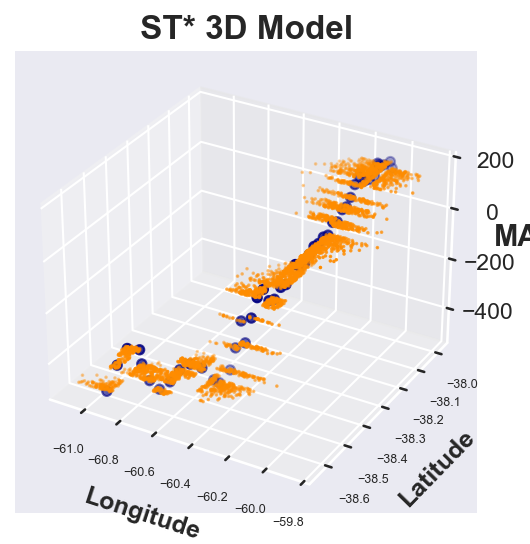

In [22]:
tree = DecisionTreeRegressor(max_depth = None, max_features=2, random_state=50)
tree.fit(X, Y)

z_ST = tree.predict(xy).reshape(-1,1)

title = "ST* 3D Model"
threedgraph(y_, x_, z_, Long, Lat, z_ST, "simple", title, long_tran, lat_tran)

soft_index = len(np.unique(z_ST))/n_cloud
print("ST* Smooth Index:", soft_index)

### ST* Computing Time

In [23]:
'''

ST* time performance

'''
timme=[]
tree = DecisionTreeRegressor(max_depth = None, max_features= 2, random_state=1)
for i in range(1000):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=i)
    time_start = time.perf_counter() #Tomamos el tiempo 
    tree.fit(x_train, y_train)
    
    time_elapsed = (time.perf_counter() - time_start)
    timme.append(time_elapsed)
    
finaltime=np.mean(timme)
print(finaltime)

0.001198712300009902


# -- Random Forest --

Results in function of forest prone
Score Test: [0.9410663608039463, 0.9558955071331358, 0.9595015899093136, 0.961509954599308, 0.9626103474130231, 0.9630868349144039, 0.9631979389982765, 0.9631986175831575, 0.9631994952814585]
Score Train: [0.9727270739090308, 0.9861402816346109, 0.9916723242776064, 0.9943449789897099, 0.9954527399249047, 0.9957365202732389, 0.9957835770157746, 0.9957880974942411, 0.9957882647922834]
Score CV: [0.9519386826800837, 0.9625868254957054, 0.9643908111072382, 0.9657794315453032, 0.9667155781359499, 0.9670396794608263, 0.9671091146617438, 0.9671186510865121, 0.9671191410833534]
MSE Train: [1366.9414539129657, 696.3737013046228, 418.06652261781915, 284.0093764378242, 228.285090726846, 213.9559661899915, 211.5802796009126, 211.35136341216136, 211.34294020631577]
MSE Test: [2513.7338797698812, 1915.0837391237624, 1766.332048380973, 1678.440228209737, 1629.6148067367474, 1608.2233714711124, 1603.693341237235, 1603.5346118545244, 1603.467064244]
Variance: [252.73

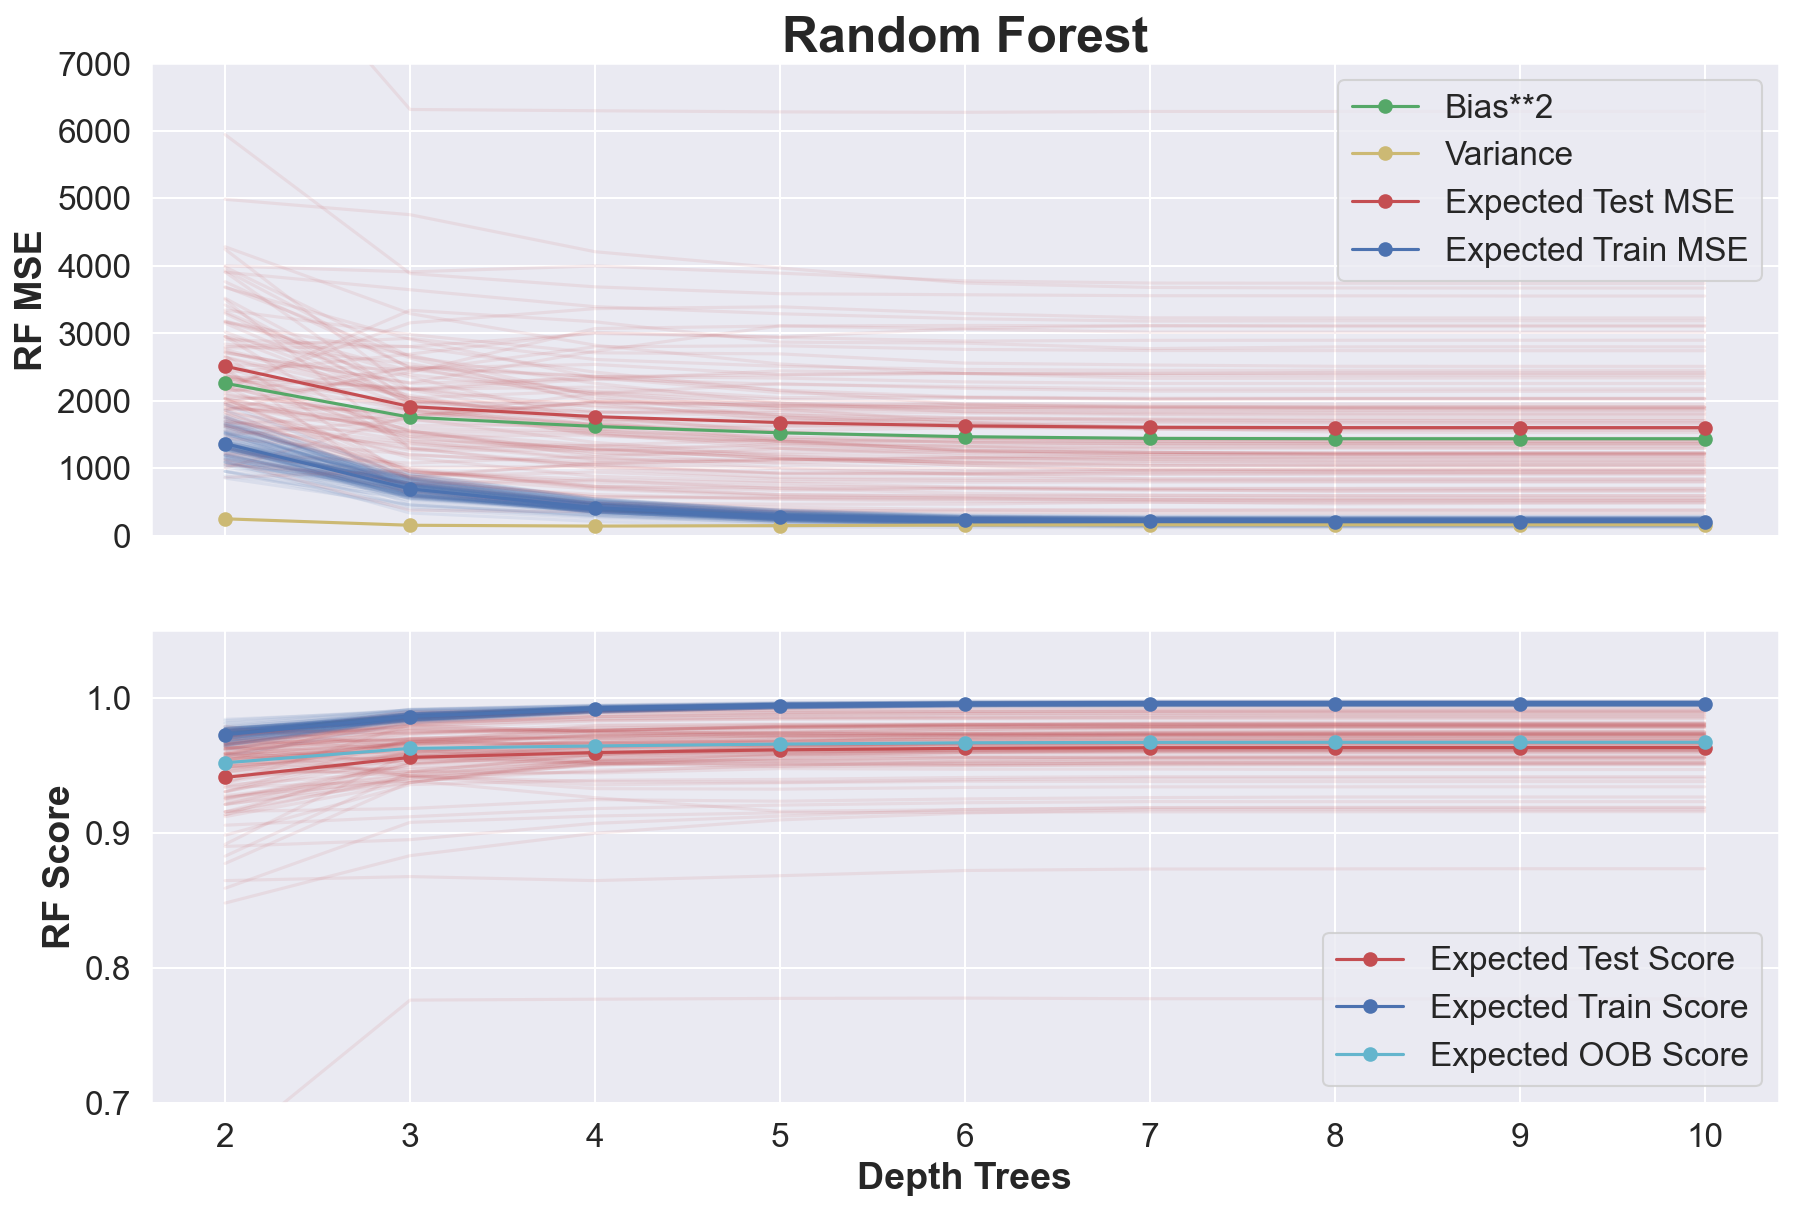

In [24]:
'''

    Random Forest implementation

'''
r = [10]
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(14, 9))
e=100
d = range(0,e) 
scoretest, coretrain, EGen, testacum, trainacum, strain, stest, rvar_acum, scv, rindex, valores = [], [], [], [], [], [], [], [], [], [], [] 
k = range(2,11)
n = len(X)
dataacum = np.zeros((9, n, 100))

for i in d:    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=i)
    
    #x_train, x_test, y_train, y_test = train_test_split(Xx, Y, test_size=0.2, random_state=i) # Secondary variables
    
    msetrain, msetest, scoretest, scoretrain, scorecv = [], [], [], [], []

    for j in k:
        
        #Avoid the use of OOB by changing "bootstrap = True" to "bootstrap = False" and then change "oob_score = True" to "False"
        #max_features is the K value. random_state is the seed 
        
        forest = RandomForestRegressor(n_jobs=-1, max_depth = j, bootstrap = True,
                                       max_features=1, min_samples_leaf = 1, oob_score = True, 
                                       n_estimators=500, random_state=1) 
        forest.fit(x_train, y_train)
        score_cv = forest.oob_score_ #Score out of bag
        rY_train = forest.oob_prediction_      #prediccion out of bag
        #cv = KFold(n_splits = 5, shuffle=True, random_state=1)
        #score_cv = np.mean(cross_val_score(forest, x_train, y_train, cv = cv, n_jobs=-1))
        rY_test = forest.predict(x_test)
        rY_train = forest.predict(x_train)
        score_train = r2_score(y_train, rY_train)
        MSE_test = sum((rY_test-y_test)**2)/len(y_test)
        MSE_train = sum((rY_train-y_train)**2)/len(y_train)
        score_test = r2_score(y_test, rY_test)
        
        Y_test_comp = np.zeros((n))
        eindex = []
        eindex = x_test.index
        
        for o in range(len(y_test)):
            Y_test_comp[eindex[o]] = rY_test[o]
        dataacum[j-2 , 0:n , i] = Y_test_comp
        
        msetrain.append(MSE_train)
        msetest.append(MSE_test)
        scoretest.append(score_test)
        scoretrain.append(score_train)
        scorecv.append(score_cv)
        
    strain.append(scoretrain)
    stest.append(scoretest)
    scv.append(scorecv)
    testacum.append(msetest)
    trainacum.append(msetrain)
    
    ax1.plot(k, msetest, "r-", alpha = 0.1)
    ax1.plot(k, msetrain, "b-", alpha = 0.1)
    ax1.set_ylim(-200, 6000)

    ax2.plot(k, scoretest, "r-", alpha = 0.1)
    ax2.plot(k, scoretrain, "b-", alpha = 0.1)
    #ax2.plot(k, scorecv, "c-", alpha = 0.1)
    ax2.set_ylim(0.8, 1.02)
    
    ax2.set_ylabel('RF Score',  fontweight='bold', fontsize=18)
    ax2.set_xlabel('Depth Trees', fontweight='bold', fontsize=18)
    ax1.set_title('Random Forest', fontweight='bold', fontsize=24)
    ax1.set_ylabel('RF MSE', fontweight='bold', fontsize=18)
    ax1.tick_params(axis='y', labelsize=16)
    ax1.tick_params(axis='x', labelsize=16)
    ax2.tick_params(axis='y', labelsize=16)
    ax2.tick_params(axis='x', labelsize=16)

sstestacum, sstrainacum, sscvacum, nnacum, mmacum = [], [], [], [], []

for i in range(0,9):
    nacum, macum, scvacum, strainacum, stestacum = [], [], [], [], []

    for j in d:
        n = trainacum[j][i]
        nacum.append(n)
        m = testacum[j][i]
        macum.append(m)
        sstest = stest[j][i]
        stestacum.append(sstest)
        sstrain = strain[j][i]
        strainacum.append(sstrain)
        scva = scv[j][i]
        scvacum.append(scva)

    nn = np.mean(nacum)
    nnacum.append(nn)
    mm = np.mean(macum)
    mmacum.append(mm)
    sstest = np.mean(stestacum)
    sstestacum.append(sstest)
    sstrain = np.mean(strainacum)
    sstrainacum.append(sstrain)
    sscv = np.mean(scvacum)
    sscvacum.append(sscv) 

fvariance = variancefunc(dataacum)
bbacum = list(np.array(mmacum) - np.array(fvariance))  
ax1.plot(k, bbacum, "go-", label= "Bias**2")
ax1.plot(k, fvariance, "yo-", label= "Variance")

ax1.plot(k, mmacum, "ro-", label= 'Expected Test MSE')
ax1.plot(k, nnacum, "bo-", label= 'Expected Train MSE')
ax1.set_ylim([0, 7000])
ax1.legend(loc='upper right', fontsize = 16)

ax2.plot(k, sstestacum, "ro-", label='Expected Test Score')
ax2.plot(k, sstrainacum, "bo-", label='Expected Train Score')
ax2.plot(k, sscvacum, "co-", label='Expected OOB Score')
ax2.set_ylim([0.7, 1.05])
ax2.legend(loc='lower right', fontsize = 16)

print("Results in function of forest prone")
print("Score Test:", sstestacum)
print("Score Train:", sstrainacum)
print("Score CV:", sscvacum)
print("MSE Train:", nnacum)
print("MSE Test:", mmacum)
print("Variance:", fvariance)
print("Bias:", bbacum)

plt.savefig("output/MendozaVeirana_et_al(2021)_RF_figure.png", dpi=300)

### RF* 3D Graph & Smoothness

c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RF* Smooth Index: 0.717


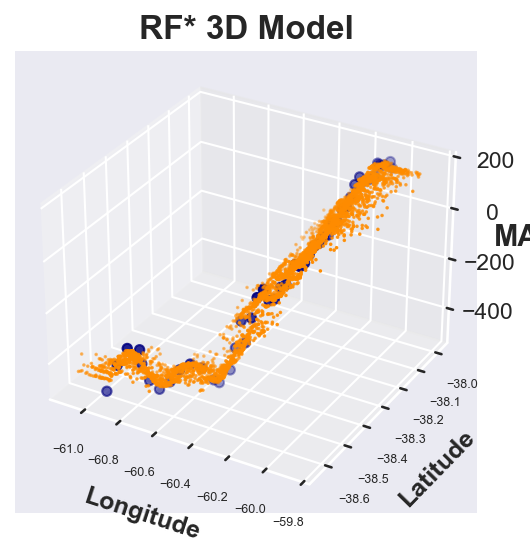

In [25]:
forest = RandomForestRegressor(n_jobs=-1, max_depth = None, bootstrap = True, min_samples_leaf = 1, 
                               oob_score=True, max_features= 1, n_estimators=500, random_state=1)
forest.fit(X, Y)

z_RF = forest.predict(xy).reshape(-1,1)

title = "RF* 3D Model"
threedgraph(y_, x_, z_, Long, Lat, z_RF, "simple", title, long_tran, lat_tran)

soft_index = len(np.unique(z_RF))/n_cloud
print("RF* Smooth Index:", soft_index)

### RF* Computing Time

In [26]:
'''

    RF* time test

'''
timme=[]
forest = RandomForestRegressor(n_jobs=-1, max_depth = None, max_features=1, bootstrap = True, min_samples_leaf = 1, oob_score=True, n_estimators=500)
for i in range(1000):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=i)
    time_start = time.perf_counter() # start time
    forest.fit(x_train,y_train)
    
    time_elapsed = (time.perf_counter() - time_start)
    timme.append(time_elapsed)
    
finaltime=np.mean(timme)
print(finaltime)

0.6701723963000095


# -- Extremely Randomized Forest --

Results in function of extra-forest prone
Score Test: [0.8706616579939821, 0.9342957062187015, 0.9580935352109935, 0.9685392080129686, 0.9728712981802642, 0.9752971430918959, 0.9761820585196981, 0.9765266229089403, 0.9765709569668648]
Score Train: [0.8787090145183026, 0.9490903534453491, 0.9772464898038798, 0.9906966602493881, 0.996132828155928, 0.9987016788362066, 0.9996417442722649, 0.999917674080476, 0.9999848334281802]
Score CV: [0.8441922398815217, 0.9208298027912657, 0.9469397738003251, 0.9573754124089342, 0.9609483333967392, 0.9627396146682744, 0.9633242608269349, 0.9634741904442081, 0.963520358933587]
MSE Train: [6069.597640183521, 2547.8553294275275, 1138.5784014342075, 465.00198961393005, 193.19490269468056, 64.71772703781694, 17.82834714841396, 4.086354362028903, 0.7516253446559154]
MSE Test: [6992.198605416689, 3508.1578706736273, 2211.2665999370056, 1647.0020505288549, 1413.9930348066805, 1284.5422302500772, 1238.0144711406006, 1220.289723145907, 1217.6243132929492]
Varaan

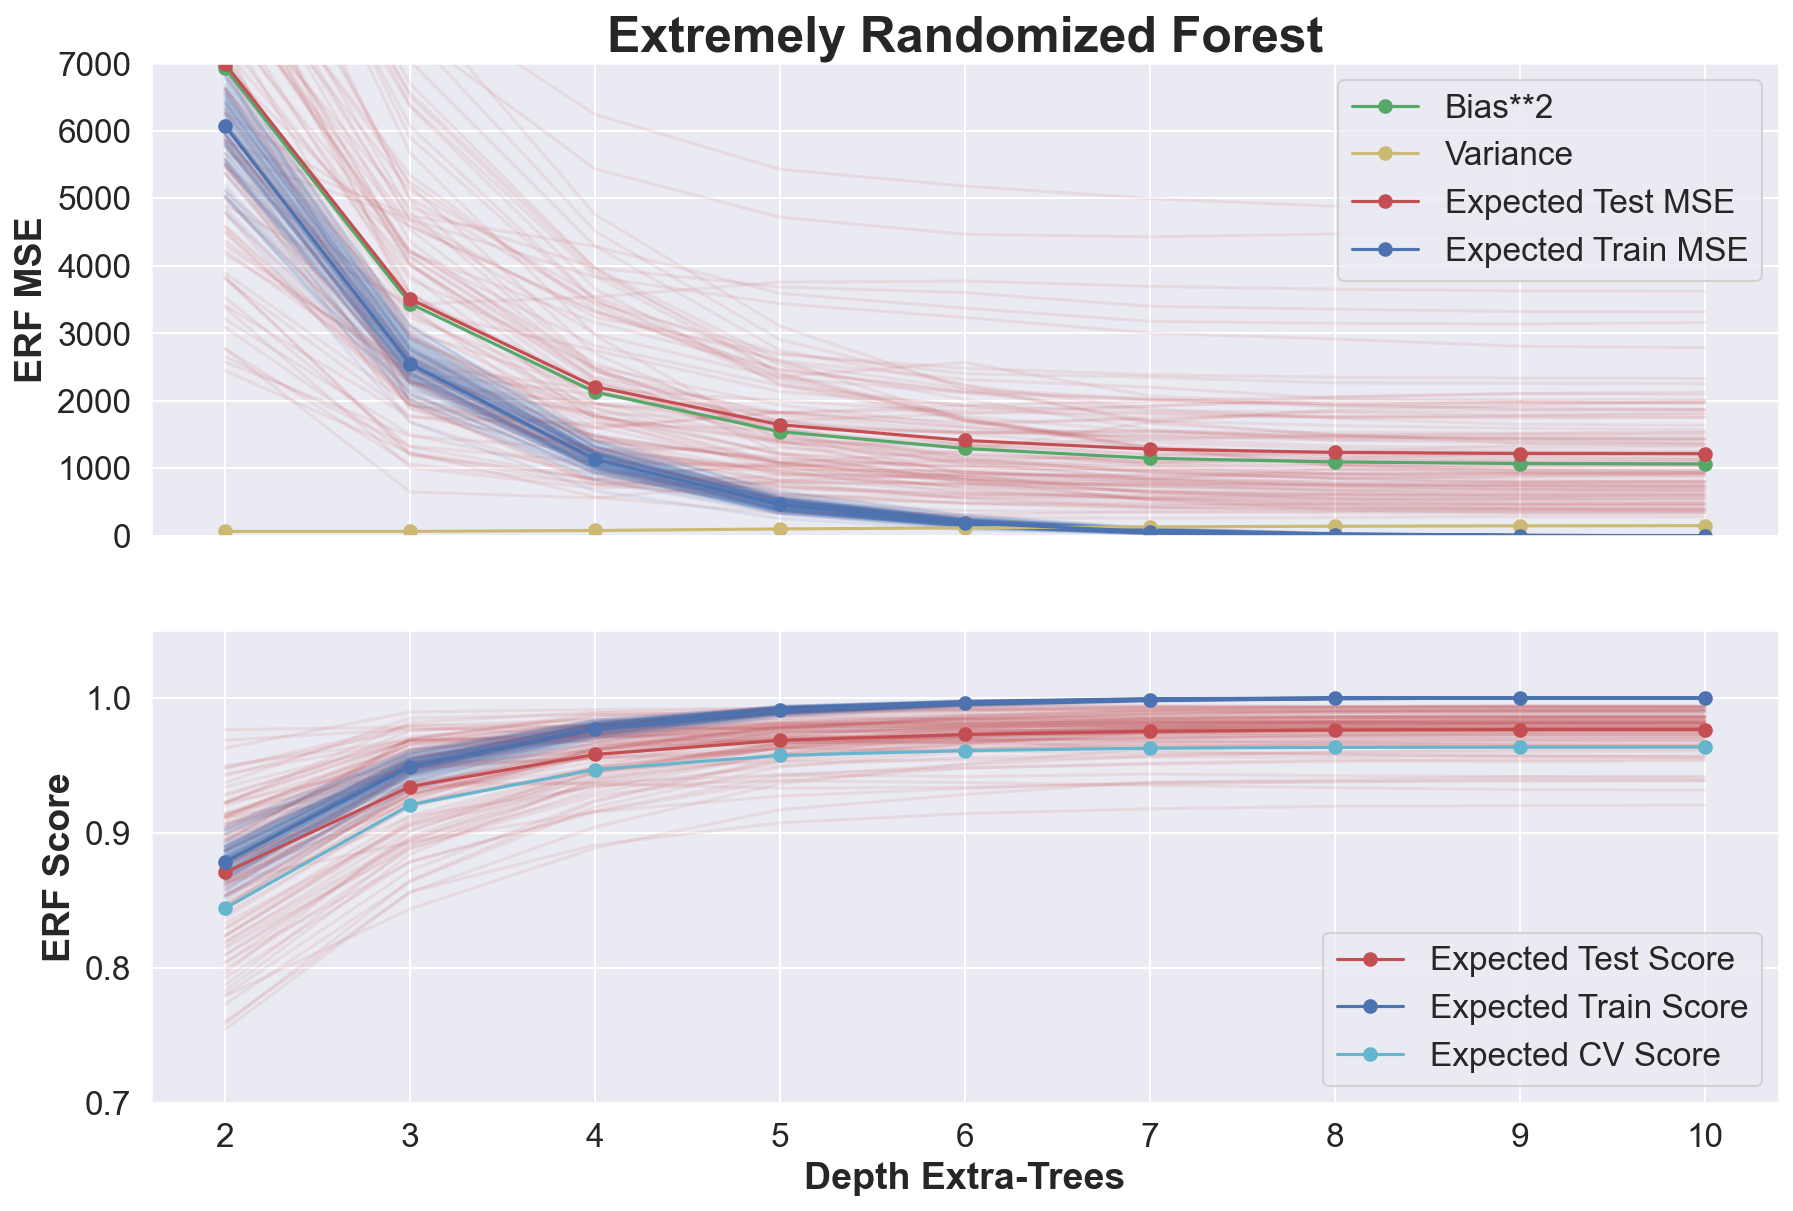

In [27]:
'''

    Extremely Randomixed Forest implementation

'''
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(14, 9))
d =  range(0,100)
msetrain, msetest, testacum, trainacum, strain, stest, scv = [], [], [], [], [], [], []
k = range(2,11)
n= len(X)
dataacum = np.zeros((9, n, 100))

for i in d:    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=i)  
    
    #x_train, x_test, y_train, y_test = train_test_split(Xx, Y, test_size=0.2, random_state=i) # Use secondary features
    
    msetrain, msetest, scoretest, scoretrain, scorecv = [], [], [], [], []

    for j in k:        
        #Use OOB by changing "bootstrap = False" to "bootstrap = True" and then change "oob_score = False" to "True"
        #'max_features' is the K value
        #'random_state' is the seed
        
        extra_forest = ETR(n_estimators=500 , max_depth = j, max_features = 1, bootstrap = False,
                           oob_score = False, random_state=1, n_jobs=-1)
        extra_forest.fit(x_train, y_train)
        y_pred = extra_forest.predict(x_train)
        eY_test = extra_forest.predict(x_test)
        MSE_train = sum((y_train - y_pred)**2)/len(y_train)
        MSE_test = sum((eY_test - y_test)**2)/len(y_test)
        score_test = np.mean(explained_variance_score(y_test, eY_test))
        score_train = np.mean(explained_variance_score(y_train, y_pred))        
        cv = KFold(n_splits =5, shuffle=True, random_state=1) #validacion cruzada
        cvs = np.mean(cross_val_score(extra_forest, x_train, y_train, cv = cv, n_jobs=-1))
        
        Y_test_comp = np.zeros((n))
        eindex = []
        eindex = x_test.index
        
        for o in range(len(y_test)):
            Y_test_comp[eindex[o]] = eY_test[o]
        dataacum[j-2 , 0:n , i] = Y_test_comp
        
        msetrain.append(MSE_train)
        msetest.append(MSE_test)
        scoretrain.append(score_train)
        scoretest.append(score_test)
        scorecv.append(cvs)
      
    strain.append(scoretrain)
    stest.append(scoretest)
    scv.append(scorecv)
    testacum.append(msetest)
    trainacum.append(msetrain)

    ax1.plot(k, msetrain, "b-", alpha = 0.1), ax1.plot(k, msetest, "r-", alpha = 0.1), ax1.set_ylim(-200, 6000)
    ax2.plot(k, scoretest, "r-", alpha = 0.1), ax2.plot(k, scoretrain, "b-", alpha = 0.1), ax2.set_ylim(0.8, 1.02)
    
    ax2.set_ylabel('ERF Score',  fontweight='bold', fontsize=18), ax2.set_xlabel('Depth Extra-Trees', fontweight='bold', fontsize=18)
    ax1.set_title('Extremely Randomized Forest', fontweight='bold', fontsize=24), ax1.set_ylabel('ERF MSE', fontweight='bold', fontsize=18)
    
    ax1.tick_params(axis='y', labelsize=16), ax1.tick_params(axis='x', labelsize=16)
    ax2.tick_params(axis='y', labelsize=16), ax2.tick_params(axis='x', labelsize=16)

sstestacum, sstrainacum, sscvacum, nnacum, mmacum = [], [], [], [], []

for i in range(0,9):
    nacum, macum, scvacum, strainacum, stestacum = [], [], [], [], []

    for j in d:

        n = trainacum[j][i]
        nacum.append(n)
        m = testacum[j][i]
        macum.append(m)
        sstest = stest[j][i]
        stestacum.append(sstest)
        sstrain = strain[j][i]
        strainacum.append(sstrain)
        scva = scv[j][i]
        scvacum.append(scva)

    nn = np.mean(nacum)
    nnacum.append(nn)
    mm = np.mean(macum)
    mmacum.append(mm)
    sstest = np.mean(stestacum)
    sstestacum.append(sstest)
    sstrain = np.mean(strainacum)
    sstrainacum.append(sstrain)
    sscv = np.mean(scvacum)
    sscvacum.append(sscv) 

evariance = variancefunc(dataacum)
bbacum = list(np.array(mmacum) - np.array(evariance))

ax1.plot(k, bbacum, "go-", label= "Bias**2")
ax1.plot(k, evariance, "yo-", label= "Variance")
ax1.plot(k, mmacum, "ro-", label='Expected Test MSE')
ax1.plot(k, nnacum, "bo-", label='Expected Train MSE')
ax1.set_ylim([0, 7000])
ax1.legend(loc='upper right', fontsize = 16)
ax2.plot(k, sstestacum, "ro-", label='Expected Test Score')
ax2.plot(k, sstrainacum, "bo-", label='Expected Train Score')
ax2.plot(k, sscvacum, "co-", label='Expected CV Score')
ax2.set_ylim([0.7, 1.05])
ax2.legend(loc='lower right', fontsize = 16)

print("Results in function of extra-forest prone")
print("Score Test:", sstestacum)
print("Score Train:", sstrainacum)
print("Score CV:", sscvacum)
print("MSE Train:", nnacum)
print("MSE Test:", mmacum)
print("Varaanza:", evariance)
print("Bias:", bbacum)

plt.savefig("output/MendozaVeirana_et_al(2021)_ERF_figure.png", dpi=300)

### ERF* 3D Graph & Smoothness

c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(


ERF* Smooth Index: 0.982


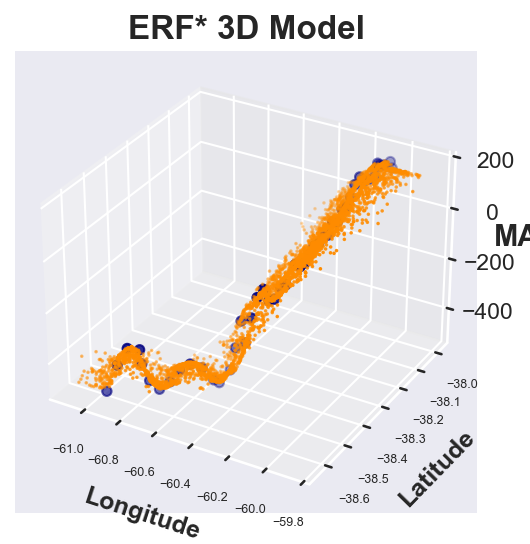

In [28]:
extra_forest = ETR(n_estimators=500, max_depth = None, max_features = 1, bootstrap = False, oob_score=False, 
                   random_state=1, n_jobs=-1)
extra_forest.fit(X, Y)

z_ERF = extra_forest.predict(xy).reshape(-1,1)
#regression = extra_forest.predict(X)

title = "ERF* 3D Model"
threedgraph(y_, x_, z_, Long, Lat, z_ERF, "simple", title, long_tran, lat_tran)

soft_index = len(np.unique(z_ERF))/n_cloud
print("ERF* Smooth Index:", soft_index)

### ERF* Computing Time

In [29]:
'''

ERF* time test

'''

timme=[]
extra_forest = ETR(n_estimators=500 , min_samples_leaf = 1, max_depth = None, max_features=1, bootstrap = False, oob_score=False, random_state=1, n_jobs=-1)
for i in range(1000):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=i)
    time_start = time.perf_counter() #Tomamos el tiempo 
    extra_forest.fit(x_train, y_train)
    
    time_elapsed = (time.perf_counter() - time_start)
    timme.append(time_elapsed)
    
finaltime=np.mean(timme)
print(finaltime)

0.38670024669999203


In [30]:
'''

Saving the output results in a CSV file

'''

output = np.column_stack([Lat, Long, z_SVM, z_ST, z_RF, z_ERF])

import csv

headers = ('Latsurf', 'Longsurf', "SVM*MASL", "ST*MASL", "RF*MASL", 'ERF*MASL')

with open('output.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(headers)
    writer.writerows(output)